In [75]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import gin
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
from vectorincrement.vectorincrementenv import SparseMatrixEnvironment
from vectorincrement.observation_encoder import KerasEncoder, KerasEncoderWrapper, linear_encoder_unbiased_normal
from helpers import EnvDataCollector
from gym.wrappers import TimeLimit

In [76]:
# state dim
n = 5

# obs dim
k = 100

# features dim
f = 5

# number of steps to generate
n_steps = 10000

In [77]:
gin.bind_parameter("KerasEncoder.model_callable", linear_encoder_unbiased_normal)
gin.bind_parameter("KerasEncoder.out_shape", (k,))

In [78]:
env = SparseMatrixEnvironment(n=n)
env = TimeLimit(env, 1000)
env = KerasEncoderWrapper(env)
env = EnvDataCollector(env)

In [79]:
A = env.env.env.A

In [80]:
np.where(A)[0] == np.where(A)[1]

array([False, False,  True, False, False])

In [81]:
# collecting data
while env.steps < n_steps:
    done = False
    env.reset()
    while not done:
        _, _, done, _ = env.step(env.action_space.sample())
    
env.flush()

In [83]:
observations = [np.array([step['observation'] for step in rollout]) for rollout in env.rollouts]

In [86]:
len(observations)

10

In [87]:
class LinearNet(nn.Module):
    """Linear neural network."""
    
    def __init__(self, inp_dim, out_dim):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(in_features=inp_dim, out_features=out_dim,
                           bias=False)
        
    def forward(self, x):
        return self.fc1(x)

In [89]:
def reconstruction_loss(obss, decoder, reconstructor):
    """Ensure that the decoder is not degenerate by fitting a reconstructor."""
    mse = torch.nn.MSELoss()
    return mse(reconstructor(decoder(obss)), obss)

def reconstruction_loss_norm(reconstructor):
    """Ensure that the decoder is not degenerate (inverse norm not too high)."""
    regularization_loss = 0
    for param in reconstructor.parameters():
        regularization_loss += torch.sum(torch.square(param))
    return regularization_loss

def fit_loss(obss, obss_prev, decoder, model):
    """Ensure that the model fits the features data."""
    mse = torch.nn.MSELoss()
    
    return mse(model(decoder(obss_prevv)), decoder(obss))

def sparsity_loss(model):
    """Ensure that the model is sparse."""
    regularization_loss = 0
    for param in model.parameters():
        regularization_loss += torch.sum(torch.abs(param))
    return regularization_loss

In [91]:
def losses(obss_torch, obss_prev_torch, decoder, reconstructor, model, rn_threshold=100):
    """Compute all losses ob observations."""
    res = {}
    res['r'] = reconstruction_loss(obss_torch, decoder, reconstructor)
    res['f'] = fit_loss(obss_torch, obss_prev_torch, decoder, model)
    res['s'] = sparsity_loss(model)
    res['rn'] = reconstruction_loss_norm(reconstructor)
    if res['rn'] < rn_threshold:
        res['rn'] = torch.from_numpy(np.array(rn_threshold))
    return res

def total_loss(losses_, hypers):
    """Compute total loss."""
    loss = 0.0
    for key in losses_.keys():
        loss += hypers[key] * losses_[key]
    return loss

def lstdct2dctlst(lst):
    """List of dictionaries -> dict of lists."""
    keys = lst[0].keys()
    result = {k: [] for k in keys}
    for item in lst:
        for k, v in item.items():
            result[k].append(v)
    return result

def epoch(obss_torch, obss_prev_torch, optimizer, decoder, reconstructor, model, hypers):
    """One optimization epoch."""
    optimizer.zero_grad()
    L = losses(obss_torch, decoder, reconstructor, model)
    loss = total_loss(L, hypers)
    loss.backward()
    optimizer.step()
    L['total'] = loss
    return {x: y.item() for x, y in L.items()}

def metrics(decoder, reconstructor, model, hypers):
    m = {}
    m['nnz'] = np.sum(np.abs(list(model.parameters())[0].detach().numpy().flatten()) > 1e-2)
    m['hyper_s'] = hypers['s']
    return m

#### Optimizing via total loss over the whole data

In [ ]:
observations = 

In [56]:
def fit_on_observations(observations, model, decoder, reconstructor, hypers):
    """Fit model/decoder/reconstructor on observations"""
    # converting observations to torch
    obss_torch = torch.from_numpy(np.array(observations, dtype=np.float32))

    all_parameters = list(model.parameters()) + list(decoder.parameters()) + list(reconstructor.parameters())
    optimizer = torch.optim.Adam(all_parameters, lr=hypers['lr'])

    # training
    last_hyper_adjustment = -1
    suggested_hyper = None
    results = []
    for i in tqdm(range(hypers['epochs'])):
        e = epoch(obss_torch, optimizer, decoder, reconstructor, model, hypers)
        e.update(metrics(decoder, reconstructor, model, hypers))
        results.append(e)

        if hypers['hyper_do_update']:
            if e['r'] + e['f'] > hypers['rf_threshold']:
                if hypers['s'] > hypers['s_min']:
                    suggested_hyper = hypers['s'] * hypers['s_decreaser']
            else:
                if hypers['s'] < hypers['s_max']:
                    suggested_hyper = hypers['s'] / hypers['s_decreaser']

            if i - last_hyper_adjustment >= hypers['hyper_freeze_steps'] and suggested_hyper is not None:
                hypers['s'] = suggested_hyper
                last_hyper_adjustment = i
            
    return results

In [72]:
def plot_losses_and_model(results, model):
    """Plot loss curves and the weight heatmap."""
    # plotting
    plt.figure(figsize=(16, 5))
    for i, (k_, v) in enumerate(lstdct2dctlst(results).items()):
        plt.subplot(1, len(results[0]) + 1, i + 1)
        plt.xlabel('epoch')
        plt.title(k_)
        plt.axhline(0)
        ax = plt.gca()
        plt.yscale('log')
        ax.tick_params(axis="y", direction="in", pad=-30)
        plt.plot(v)

    plt.subplot(1, len(results[0]) + 1, len(results[0]) + 1)
    plt.title("Weights heatmap")
    sns.heatmap(list(model.parameters())[0].detach().numpy())

In [58]:
# creating models
decoder = LinearNet(inp_dim=k, out_dim=f)
reconstructor = LinearNet(inp_dim=f, out_dim=k)
model = LinearNet(inp_dim=f, out_dim=f)

In [59]:
hypers_dry = {'r': 0.1, 'f': 0.2, 's': 0.0, 'rn': 0.0, 'lr': 1e-3, 'epochs': 5000,
              'hyper_do_update': False,
             }
k, f, len(observations)

(100, 5, 1000)

In [60]:
results_dry = fit_on_observations(observations, model, decoder, reconstructor, hypers_dry)

100%|██████████| 5000/5000 [00:10<00:00, 483.71it/s]


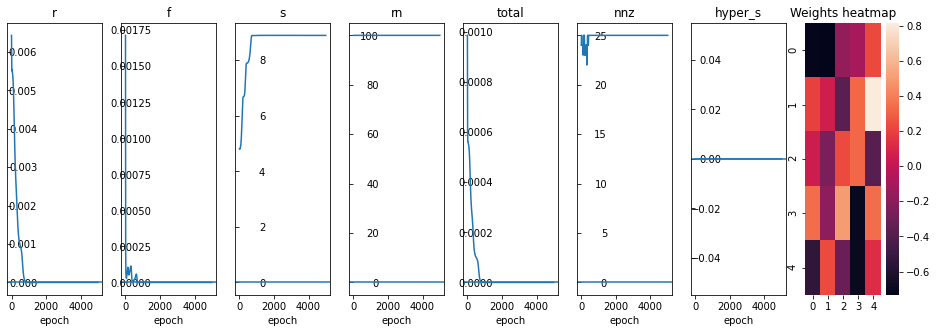

In [31]:
plot_losses_and_model(results_dry, model)

In [66]:
hypers = {'r': 0.1, 'f': 0.2, 's': 1e-10, 'rn': 0.0001, 'lr': 1e-3,
          'rf_threshold': 100 * (results_dry[-1]['r'] + results_dry[-1]['f']),
          'epochs': 10000,
          's_min': 1e-10, 's_max': 10,
          's_decreaser': 0.5,
          'hyper_freeze_steps': 100,
          'hyper_do_update': True
         }
k, f, len(observations)

(100, 5, 1000)

In [67]:
# creating models
decoder = LinearNet(inp_dim=k, out_dim=f)
reconstructor = LinearNet(inp_dim=f, out_dim=k)
model = LinearNet(inp_dim=f, out_dim=f)

In [69]:
results = fit_on_observations(observations, model, decoder, reconstructor, hypers)

 94%|█████████▍| 9434/10000 [00:19<00:01, 524.29it/s]

limit_output extension: Maximum message size of 10000 exceeded with 10009 characters

/home/sergei/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # This is added back by InteractiveShellApp.init_path()


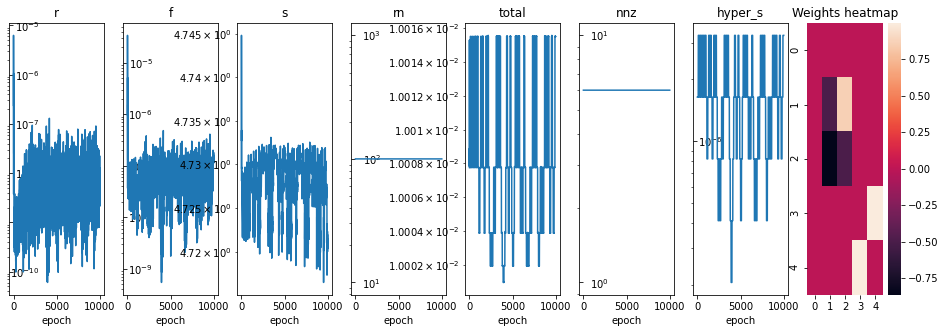

In [74]:
plot_losses_and_model(results, model)

In [71]:
results[-1]

{'r': 2.1763635338345466e-09,
 'f': 1.2383853231767716e-07,
 's': 4.720606327056885,
 'rn': 100,
 'total': 0.010015493258833885,
 'nnz': 6,
 'hyper_s': 3.2768e-06}